Parameters - Plant Profile: bright_and_spicy, Start Date: 2024-01-01, End Date: 2024-12-31, Layer IDs: [6935, 6943], X Position: None, Y Position: None, Max Side Images: None, Max Top Images: None, Desired Matches: 10, Remove Duplicates: True, Output CSV Path: matches_side_top.csv


INFO:__main__:Changed working directory to: /home/ec2-user/SageMaker/notebooks/height_prediction_brispi


CSV file matches_side_top.csv already exists. Skipping creation.


/tmp/ipykernel_13462/899975635.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_filtered.groupby('coordinates').apply(filter_within_range).reset_index(drop=True)


Filtered unique bright_and_spicy images: 3910
Side images: 1666
Top images: 2244
No matching top image found for s3://growx-landingzone/photos/farm-4/2024/03/18/f70884ec-1467-4a5d-aa78-f0f8f38cafb6/6943_x_1089_y_12253_z_125_side_2024_03_18_14_01_52_white.jpg
No matching top image found for s3://growx-landingzone/photos/farm-4/2024/03/18/f70884ec-1467-4a5d-aa78-f0f8f38cafb6/6943_x_2053_y_12253_z_125_side_2024_03_18_14_02_25_white.jpg
Starting to download matched images...


INFO:__main__:All images processed successfully.


Finished downloading matched images.


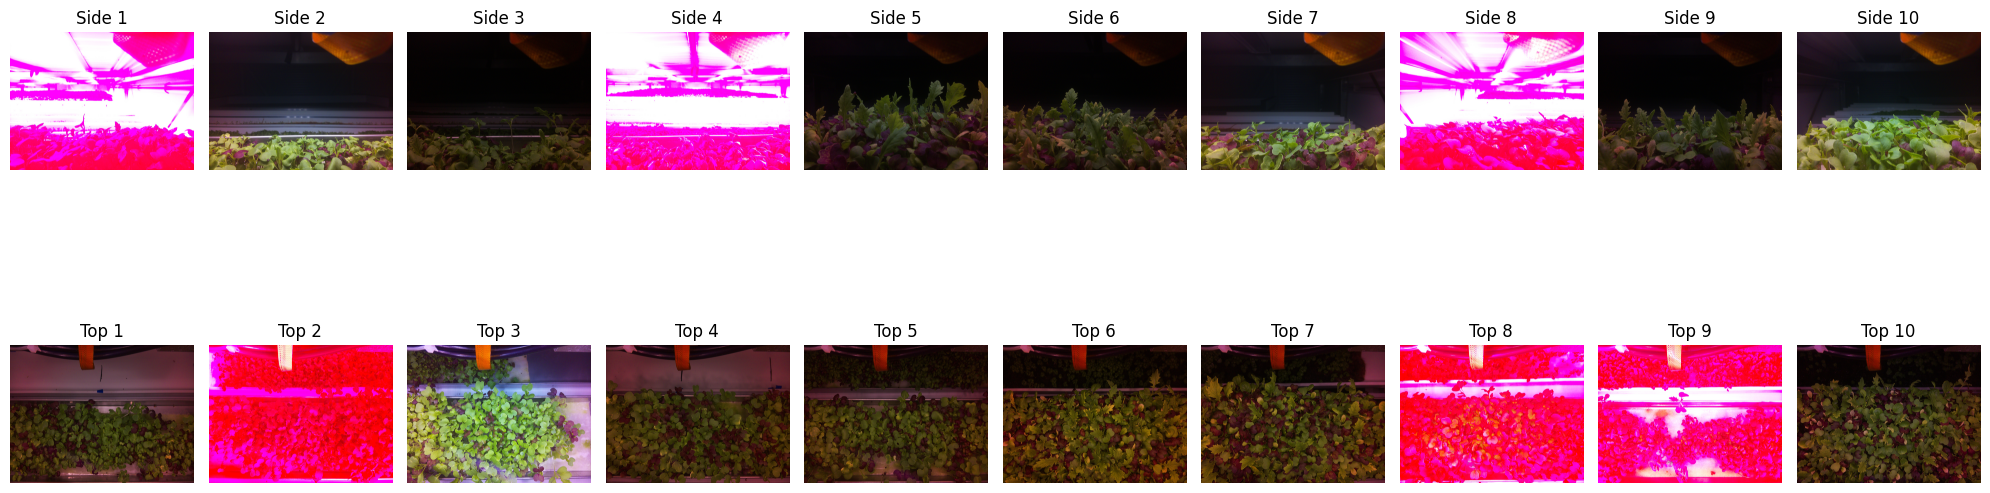

In [7]:
import os
import pandas as pd
import boto3
from urllib.parse import urlparse
from eda.session_helper import AwsCredentials
from eda.experiments.yields import YieldData
from eda.sensors.images import PlantImageMetadata, PlantImage, CameraMetaData
import logging
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import re
from datetime import datetime, timedelta

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Section 1: Initialize and Set Up
def initialize_aws(credentials=AwsCredentials, working_directory='/home/ec2-user/SageMaker/notebooks/height_bright_spicy'):
    """Initialize AWS credentials and change working directory."""
    credentials()
    os.chdir(working_directory)
    logger.info(f"Changed working directory to: {os.getcwd()}")

# Section 2: Load and Filter Image Metadata
def load_image_metadata(start_path, color_filter='white'):
    """Load and filter image metadata from S3."""
    plant_image_metadata = PlantImageMetadata()
    image_df = plant_image_metadata.image_dataframe(start_path).drop_duplicates()
    return image_df[image_df['color'] == color_filter]

# Section 3: Retrieve and Process SQL Data
def retrieve_sql_data(start_date='2024-01-01', end_date='2024-12-31', layer_ids=[6935, 6943]):
    """Retrieve data from Athena using SQL."""
    get_ipython().run_line_magic('reload_ext', 'eda.athena')
    query = f"""
    SELECT
        i.farm_id,
        i.cell_id,
        i.layer_id,
        i.slot_id,
        pp.plant_profile_name,
        REGEXP_REPLACE(
            REGEXP_REPLACE(
                pp.plant_profile_name, '(_[0-9]+x[0-9]+_[0-9]+x[0-9]+)(.*)$', ''
            ), 
            '(_[0-9]+x[0-9]+_(Experiment|Long|Short|Normal)(.*))$', ''
        ) AS cultivar,
        i.attr1 as instruction,
        pp.growth_cycle_id,
        to_iso8601(start_datetime) as start_datetime,
        DATE(start_datetime) AS instruction_date
    FROM data_vault.hs_lcm_instructions_test i
    LEFT JOIN data_vault.hs_lcm_production_plan_test pp ON pp.growth_cycle_id = i.growth_cycle_id
    WHERE start_datetime BETWEEN DATE('{start_date}') AND DATE('{end_date}')
    AND i.layer_id in ({', '.join(map(str, layer_ids))})
    ORDER BY pp.growth_cycle_id, i.slot_id;
    """
    get_ipython().run_cell_magic('sql', 'wf', query)
    return wf.drop_duplicates()

def merge_dataframes(df, wf):
    """Merge image metadata with SQL data."""
    return df.merge(wf[['growth_cycle_id', 'plant_profile_name', 'cultivar']], left_on='gc', right_on='growth_cycle_id', how='left').drop_duplicates()

def parse_timestamp(filename):
    """Parse the timestamp from the filename."""
    match = re.search(r'(\d{4}_\d{2}_\d{2}_\d{2}_\d{2})', filename)
    if match:
        return datetime.strptime(match.group(1), '%Y_%m_%d_%H_%M')
    return None

def extract_coordinates(filename):
    """Extract x, y, z coordinates from the filename."""
    match = re.search(r'(\d+)_x_(\d+)_y_(\d+)_z_', filename)
    if match:
        return match.groups()
    return None, None, None

def find_closest_top_image(side_filename, top_images_df, time_tolerance_seconds=1200):
    """Find the closest top image based on timestamp."""
    x, y, z = extract_coordinates(side_filename)
    if not all([x, y, z]):
        return None

    coordinates = f"{x}_x_{y}_y_{z}_z_"
    side_image_timestamp = parse_timestamp(side_filename)
    if not side_image_timestamp:
        return None

    matching_images = top_images_df[top_images_df['path'].str.contains(coordinates)]
    
    closest_image = None
    min_time_diff = float('inf')

    for _, row in matching_images.iterrows():
        top_image_filename = row['path']
        top_image_timestamp = parse_timestamp(top_image_filename)
        if top_image_timestamp:
            time_diff = abs((top_image_timestamp - side_image_timestamp).total_seconds())
            if time_diff < min_time_diff and time_diff <= time_tolerance_seconds:
                min_time_diff = time_diff
                closest_image = top_image_filename

    return closest_image

def match_images(side_images_df, top_images_df, desired_matches=None):
    """Match side and top images based on timestamp proximity until desired matches are found."""
    matched_pairs = []
    match_count = 0

    for _, side_row in side_images_df.iterrows():
        if desired_matches and match_count >= desired_matches:
            break

        side_image_filename = side_row['path']
        closest_top_image_filename = find_closest_top_image(side_image_filename, top_images_df, time_tolerance_seconds=1200)
        
        if closest_top_image_filename:
            matched_pairs.append({
                'side_image': side_image_filename, 
                'top_image': closest_top_image_filename,
                'side_image_filename': os.path.basename(side_image_filename),
                'top_image_filename': os.path.basename(closest_top_image_filename)
            })
            match_count += 1
        else:
            print(f"No matching top image found for {side_image_filename}")

    return pd.DataFrame(matched_pairs)

# Section 4: Filter and Match Images
def filter_and_match_images(df, plant_profile_filter, x_position=None, y_position=None, max_side_images=None, max_top_images=None, desired_matches=None, remove_duplicates=True):
    """Filter and match images based on profile names and positions."""
    # Filter unique plant profile images based on x and y positions
    if x_position and y_position:
        position_filter = f"{x_position}_x_{y_position}_y_"
        df_filtered = df[df['plant_profile_name'].str.contains(plant_profile_filter, case=False) & df['path'].str.contains(position_filter)].drop_duplicates(subset='path')
    else:
        df_filtered = df[df['plant_profile_name'].str.contains(plant_profile_filter, case=False)].drop_duplicates(subset='path')
    
    # Extract coordinates and timestamps
    df_filtered['coordinates'] = df_filtered['path'].apply(lambda x: '_'.join(extract_coordinates(x)))
    df_filtered['timestamp'] = df_filtered['path'].apply(parse_timestamp)
    
    if remove_duplicates:
        # Group by coordinates and select images within a one-minute range of each other
        def filter_within_range(group):
            group = group.sort_values('timestamp')
            filtered_group = []
            last_time = None

            for _, row in group.iterrows():
                current_time = row['timestamp']
                if last_time is None or (current_time - last_time) > timedelta(minutes=1):
                    filtered_group.append(row)
                    last_time = current_time

            return pd.DataFrame(filtered_group)

        df_filtered = df_filtered.groupby('coordinates').apply(filter_within_range).reset_index(drop=True)
    
    side_images = df_filtered[df_filtered['path'].str.contains('side', case=False)].sort_values(by='timestamp')
    top_images = df_filtered[df_filtered['path'].str.contains('top', case=False)].sort_values(by='timestamp')
    
    if max_side_images:
        side_images = side_images.head(max_side_images)
    if max_top_images:
        top_images = top_images.head(max_top_images)
    
    print(f"Filtered unique {plant_profile_filter} images: {len(df_filtered)}")
    print(f"Side images: {len(side_images)}")
    print(f"Top images: {len(top_images)}")
    
    # Match side and top images
    matched_images = match_images(side_images, top_images, desired_matches)
    
    return matched_images

# Section 5: Download Images
def setup_directories(base_dir, sub_dirs):
    """Create necessary local directories."""
    for sub_dir in sub_dirs:
        os.makedirs(os.path.join(base_dir, sub_dir), exist_ok=True)

def image_exists(s3_uri, directory):
    """Check if an image exists in a given directory."""
    filename = os.path.basename(urlparse(s3_uri).path)
    return os.path.exists(os.path.join(directory, filename))

def download_image(s3_uri, local_dir, s3_client):
    """Download an image from S3."""
    parsed_url = urlparse(s3_uri)
    bucket = parsed_url.netloc
    key = parsed_url.path.lstrip('/')
    local_filename = os.path.join(local_dir, os.path.basename(key))
    s3_client.download_file(bucket, key, local_filename)
    return local_filename

def download_images(matched_images, base_dir, s3_client):
    """Download matched side and top images."""
    side_dir = os.path.join(base_dir, 'side_images')
    top_dir = os.path.join(base_dir, 'top_images')

    print("Starting to download matched images...")
    for _, row in matched_images.iterrows():
        side_s3_uri = row['side_image']
        top_s3_uri = row['top_image']

        if not image_exists(side_s3_uri, side_dir):
            download_image(side_s3_uri, side_dir, s3_client)
        if not image_exists(top_s3_uri, top_dir):
            download_image(top_s3_uri, top_dir, s3_client)
    
    print("Finished downloading matched images.")
    logger.info('All images processed successfully.')

# Section 6: Plot Images
def plot_random_images(base_dir, num_samples=10):
    """Plot random samples of side and top images."""
    side_dir = os.path.join(base_dir, 'side_images')
    top_dir = os.path.join(base_dir, 'top_images')
    
    side_images = os.listdir(side_dir)
    top_images = os.listdir(top_dir)

    # Ensure num_samples does not exceed available images
    num_samples = min(num_samples, len(side_images), len(top_images))
    
    side_images = random.sample(side_images, num_samples)
    top_images = random.sample(top_images, num_samples)
    
    fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(num_samples * 2, 8))
    
    for i, img in enumerate(side_images):
        img_path = os.path.join(side_dir, img)
        img_data = mpimg.imread(img_path)
        axes[0, i].imshow(img_data)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Side {i+1}')
    
    for i, img in enumerate(top_images):
        img_path = os.path.join(top_dir, img)
        img_data = mpimg.imread(img_path)
        axes[1, i].imshow(img_data)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Top {i+1}')
    
    plt.tight_layout()
    plt.show()

def save_matches_to_csv(matched_images, output_path):
    """Save the matched images DataFrame to a CSV file."""
    matched_images[['side_image_filename', 'top_image_filename']].to_csv(output_path, index=False)
    logger.info(f"Matched images saved to {output_path}")

# Main Execution
def main(
    aws_credentials=AwsCredentials,  # AWS credentials class or object
    working_directory='/home/ec2-user/SageMaker/notebooks/height_prediction_brispi',  # Working directory path
    start_path='s3://growx-landingzone/photos/farm-4/2024',  # S3 start path for images
    base_dir='/home/ec2-user/SageMaker/notebooks/height_prediction_brispi/brispi',  # Base directory for image storage
    sub_dirs=['side_images', 'top_images'],  # Subdirectories for side and top images
    plant_profile_filter='bright_and_spicy',  # Filter for plant profile names
    start_date='2024-01-01',  # Start date for SQL data retrieval
    end_date='2024-12-31',  # End date for SQL data retrieval
    layer_ids=[6935, 6943],  # List of layer IDs to include in the SQL query
    x_position=None,  # Optional filter for x position
    y_position=None,  # Optional filter for y position
    max_side_images=None,  # Optional maximum number of side images to download
    max_top_images=None,  # Optional maximum number of top images to download
    desired_matches=10,  # Optional desired number of matches between side and top images
    remove_duplicates=True,  # Turn on duplicate removal
    output_csv_path='matches_side_top.csv'  # Path to save the matches CSV file
):
    # Print all the parameters for clarity
    print(f"Parameters - Plant Profile: {plant_profile_filter}, Start Date: {start_date}, End Date: {end_date}, Layer IDs: {layer_ids}, X Position: {x_position}, Y Position: {y_position}, Max Side Images: {max_side_images}, Max Top Images: {max_top_images}, Desired Matches: {desired_matches}, Remove Duplicates: {remove_duplicates}, Output CSV Path: {output_csv_path}")
    
    # Initialize AWS and set working directory
    initialize_aws(aws_credentials, working_directory)
    
    # Load and filter image metadata
    df = load_image_metadata(start_path)
    
    # Retrieve and process SQL data
    wf = retrieve_sql_data(start_date, end_date, layer_ids)
    df = merge_dataframes(df, wf)
    
    # Set up directories for image storage
    setup_directories(base_dir, sub_dirs)
    
    # Initialize S3 client
    s3_client = boto3.client('s3')
    
    # Check if the CSV already exists
    if not os.path.exists(output_csv_path):
        print("Finding all matches and creating CSV...")
        all_side_images = df[df['path'].str.contains('side', case=False)].sort_values(by='timestamp')
        all_top_images = df[df['path'].str.contains('top', case=False)].sort_values(by='timestamp')
        all_matches = match_images(all_side_images, all_top_images)
        save_matches_to_csv(all_matches, output_csv_path)
    else:
        print(f"CSV file {output_csv_path} already exists. Skipping creation.")
    
    # Determine whether to remove duplicates based on the presence of desired_matches parameter
    if remove_duplicates is None:
        remove_duplicates = desired_matches is not None
    
    # Filter and match images
    matched_images = filter_and_match_images(df, plant_profile_filter, x_position, y_position, max_side_images, max_top_images, desired_matches, remove_duplicates)
    
    # Download matched images
    download_images(matched_images, base_dir, s3_client)
    
    # Plot random samples of images
    plot_random_images(base_dir)

if __name__ == "__main__":
    main()


In [15]:
# check size of folders
import os

# Change to your desired directory
os.chdir('/home/ec2-user/SageMaker/notebooks/height_prediction_brispi')

def get_size(start_path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def human_readable_size(size, decimal_places=2):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB', 'PB']:
        if size < 1024.0:
            return f"{size:.{decimal_places}f} {unit}"
        size /= 1024.0

def print_directory_sizes(path):
    sizes = []
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            size = get_size(item_path)
        else:
            size = os.path.getsize(item_path)
        sizes.append((item, size))
    
    # Sort the sizes list by size in descending order
    sizes.sort(key=lambda x: x[1], reverse=True)
    
    for item, size in sizes:
        print(f"{item}: {human_readable_size(size)}")

# Print sizes of files and directories
print_directory_sizes(os.getcwd())

weights: 1.64 GB
brispi: 42.67 MB
GroundingDINO: 24.87 MB
.ipynb_checkpoints: 2.81 MB
matches_side_top.csv: 1.63 MB
image_retrieval.ipynb: 1.24 MB
SAM_DINO.ipynb: 89.51 KB
README.md: 3.35 KB
.~SAM_DINO.ipynb: 0.00 B


In [18]:
# clean trash

import os
os.chdir('/home/ec2-user/SageMaker/notebooks/height_prediction_brispi')

def clean_trash():
    """Empty the Trash folder if disk space error occurs."""
    # Remove all contents of the Trash folders
    os.system('rm -rf /home/ec2-user/SageMaker/.Trash-1000/files')
    os.system('rm -rf /home/ec2-user/SageMaker/.Trash-1000/info')
    
    # Recreate the directories to avoid any issues with the Trash system
    os.makedirs('/home/ec2-user/SageMaker/.Trash-1000/files')
    os.makedirs('/home/ec2-user/SageMaker/.Trash-1000/info')
    
    # List the contents of the directories to confirm they are empty
    os.system('ls -lah /home/ec2-user/SageMaker/.Trash-1000/files')
    os.system('ls -lah /home/ec2-user/SageMaker/.Trash-1000/info')

# Call the function to clean the trash
clean_trash()

total 8.0K
drwxrwxr-x 2 ec2-user ec2-user 4.0K Aug  5 22:54 .
drwx------ 4 ec2-user ec2-user 4.0K Aug  5 22:54 ..
total 8.0K
drwxrwxr-x 2 ec2-user ec2-user 4.0K Aug  5 22:54 .
drwx------ 4 ec2-user ec2-user 4.0K Aug  5 22:54 ..


In [11]:
# delete file if disk is full

import os

# Define the path to the file you want to delete
file_path = '/home/ec2-user/SageMaker/notebooks/height_prediction_brispi/file_you_want_to_delete'

# Check if the file exists
if os.path.exists(file_path):
    # Delete the file
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print(f"{file_path} does not exist.")

/home/ec2-user/SageMaker/notebooks/height_prediction_brispi/file_you_want_to_delete does not exist.
